# Gender Prediction

## Importing Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score  , precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, classification_report

## Loading Data

In [2]:
df = pd.read_csv('name_gender_all.csv', header= None)
df.head()

,0,1
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


## Preprocessing

In [3]:
# Adding Column names to the data
df.columns = ['Name','Gender']
df.head()

,Name,Gender
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


In [4]:
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Gender
0,mary,F
1,anna,F
2,emma,F
3,elizabeth,F
4,minnie,F


In [5]:
df = df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158092 entries, 0 to 166155
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Name    158092 non-null  object
 1   Gender  158092 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [7]:
# Encoding Target Variable
le = LabelEncoder()
df['Gender'] =le.fit_transform(df['Gender'])
df

,Name,Gender
0,mary,0
1,anna,0
2,emma,0
3,elizabeth,0
4,minnie,0
...,...,...
166151,zujaan,1
166152,zujivan,1
166153,zukran,1
166154,zukreevan,1


- Female = 0
- Male = 1

In [8]:
# Selecting the Feature and target variable
X = df['Name']
y = df['Gender']

In [55]:
# spliting the dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state= 42, stratify=y)

## Model Building

### UDF for model evaluation

In [47]:
def evaluate(model,xtest,ytest):
    predictions = model.predict(xtest)
    print(f'Accuracy = {round(accuracy_score(ytest, predictions),4)}')
    print(f'Precision = {round(precision_score(ytest, predictions),4)}')
    print(f'Recall = {round(recall_score(ytest, predictions),4)}')
    print(f'F1 Score = {round(f1_score(ytest, predictions),4)}')
    print(f'\nClassification Report :-')
    print(classification_report(ytest, predictions))

### Creating Pipeline for Logistic Regression Model

In [108]:
lr = make_pipeline(CountVectorizer(analyzer= 'char', ngram_range=(2,4)), LogisticRegression(random_state= 42))
lr.fit(X_train,y_train)
evaluate(lr,X_test,y_test)

Accuracy = 0.8399
Precision = 0.819
Recall = 0.807
F1 Score = 0.813

Classification Report :-
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     17984
           1       0.82      0.81      0.81     13635

    accuracy                           0.84     31619
   macro avg       0.84      0.84      0.84     31619
weighted avg       0.84      0.84      0.84     31619



### Creating Pipeline for NultinomialNB

In [90]:
mnb = make_pipeline(CountVectorizer(analyzer= 'char', ngram_range=(2,4)), MultinomialNB())
mnb.fit(X_train,y_train)
evaluate(mnb,X_test,y_test)

Accuracy = 0.7255
Precision = 0.676
Recall = 0.6981
F1 Score = 0.6869

Classification Report :-
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     17984
           1       0.68      0.70      0.69     13635

    accuracy                           0.73     31619
   macro avg       0.72      0.72      0.72     31619
weighted avg       0.73      0.73      0.73     31619



### Creating Pipeline for XGBoost Classifier Model

In [91]:
xgb = make_pipeline(CountVectorizer(analyzer= 'char', ngram_range=(2,4)), XGBClassifier())
xgb.fit(X_train,y_train)
evaluate(xgb,X_test,y_test)

Accuracy = 0.7921
Precision = 0.7702
Recall = 0.7382
F1 Score = 0.7538

Classification Report :-
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     17984
           1       0.77      0.74      0.75     13635

    accuracy                           0.79     31619
   macro avg       0.79      0.79      0.79     31619
weighted avg       0.79      0.79      0.79     31619



## Model Evaluation

### Creating Metrics Table for Different models

In [200]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

def metrics_table(name, model, xtest, ytest, metrics_df):
    y_pred = model.predict(xtest)
    
    try:
        y_pred_prob = model.predict_proba(xtest)[:, 1]
        auc = roc_auc_score(ytest, y_pred_prob)
    except:
        auc = None

    new_row = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy_score(ytest, y_pred)],
        'Precision': [precision_score(ytest, y_pred)],
        'Recall': [recall_score(ytest, y_pred)],
        'F1-Score': [f1_score(ytest, y_pred)],
        'AUC': [auc]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
    return metrics_df

In [201]:
models = {'Logistic Regression' :lr,
          'Multinomial NB': mnb,
          'Xgboost': xgb
}

In [202]:
for name, model in models.items():
    metrics_df = metrics_table(name, model, X_test, y_test, metrics_df)

metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Logistic Regression,0.839875,0.818994,0.807041,0.812973,0.915835
1,Multinomial NB,0.725545,0.676042,0.698056,0.686873,0.801764
2,Xgboost,0.792119,0.770202,0.738174,0.753848,0.875045


### Confusion Matrics for Different Models

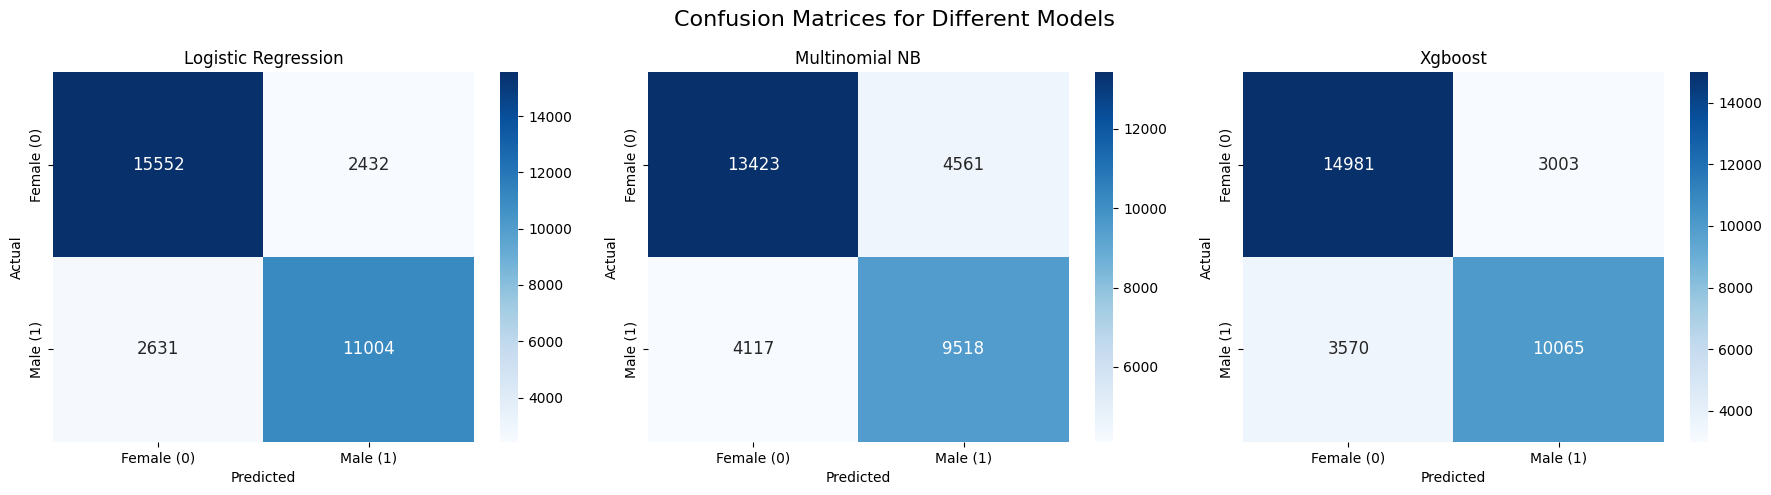

In [207]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)
i = 0
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={'size': 12}, xticklabels=['Female (0)','Male (1)'], yticklabels=['Female (0)','Male (1)'], cmap='Blues', ax= axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    i += 1
plt.tight_layout()
plt.show()

### AUC - ROC Curve (For Best Model i.e `Logistic Regression`)

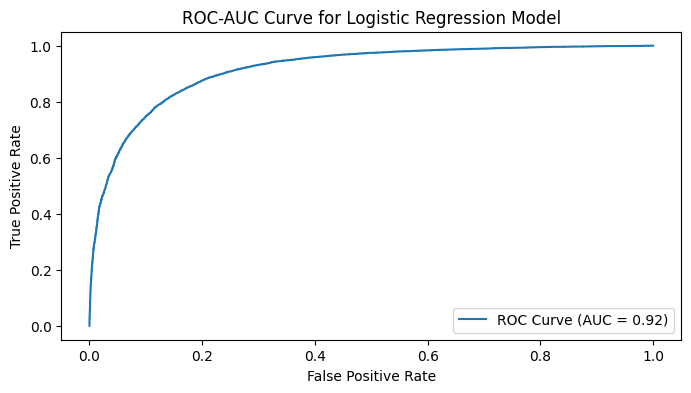

In [209]:
# ROC-AUC Curve
plt.figure(figsize=(8, 4))
y_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label= f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.title("ROC-AUC Curve for Logistic Regression Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model Deployment

In [211]:
joblib.dump(lr, "logistic regression.pkl")

['logistic regression.pkl']